# Preparation
Let us first do some preparatory steps by importing necessary libraries and loading the dataset

In [19]:
pip install --upgrade category_encoders

     |████████████████████████████████| 81kB 4.7MB/s 


In [15]:
# Import libraries to be used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Load the dataset
df_playstore = pd.read_csv("/content/drive/MyDrive/Datasets/googleplaystore.csv", na_values=np.nan, encoding="utf-8")
# Remove all "Varies with device" values
df_playstore = df_playstore.replace("Varies with device", np.nan)
# Shuffle rows
df_playstore = df_playstore.sample(frac=1)
df_playstore.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
6170,BG Cricket,SPORTS,NaN,6,24M,500+,Free,0,Everyone,Sports,"June 14, 2018",2.4.4,4.2 and up
9568,Weather by eltiempo.es,WEATHER,4.2,67854,NaN,"5,000,000+",Free,0,Everyone,Weather,"August 2, 2018",NaN,NaN
5090,Ag Tools,TOOLS,NaN,2,18M,"1,000+",Free,0,Everyone,Tools,"September 27, 2017",1,4.0.3 and up
10826,Frim: get new friends on local chat rooms,SOCIAL,4.0,88486,NaN,"5,000,000+",Free,0,Mature 17+,Social,"March 23, 2018",NaN,NaN
56,Gas Prices (Germany only),AUTO_AND_VEHICLES,4.4,805,5.6M,"50,000+",Free,0,Everyone,Auto & Vehicles,"July 29, 2018",2.5.1,4.4 and up


# Clean data

To clean the dataset, few steps should be done:

*   Remove the duplicate rows that may cause data leakage
*   Fill in the single missing value for Type
*   Remove unit in Size and convert them to the same measurement
*   Remove symbols (',' and '+') on the Installs variable
*   Remove currency on Price
*   Remove rows with missing Content Rating

Note: Row 10472 was manually shifted in the CSV file.

In [16]:
def reindex(df):
  # Remove duplicate rows based on App variable
  df.drop_duplicates(subset='App', keep="first", inplace=True)

  # Set App column as row index
  df = df.set_index('App')

  return df

df_playstore_reindexed = reindex(df_playstore.copy()) 
df_playstore_reindexed.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
App,,,,,,,,,,,,
BG Cricket,SPORTS,NaN,6,24M,500+,Free,0,Everyone,Sports,"June 14, 2018",2.4.4,4.2 and up
Weather by eltiempo.es,WEATHER,4.2,67854,NaN,"5,000,000+",Free,0,Everyone,Weather,"August 2, 2018",NaN,NaN
Ag Tools,TOOLS,NaN,2,18M,"1,000+",Free,0,Everyone,Tools,"September 27, 2017",1,4.0.3 and up
Frim: get new friends on local chat rooms,SOCIAL,4.0,88486,NaN,"5,000,000+",Free,0,Mature 17+,Social,"March 23, 2018",NaN,NaN
Gas Prices (Germany only),AUTO_AND_VEHICLES,4.4,805,5.6M,"50,000+",Free,0,Everyone,Auto & Vehicles,"July 29, 2018",2.5.1,4.4 and up


In [17]:
def clean_df(df):
  # Type only has 1 missing value, we can derive its value based on the
  # price of the sample which is 0
  df['Type'] = df['Type'].map(lambda x: 'Free' if pd.isna(x) else x)

  # Remove the unit and convert Size into the same measurement
  df['Size'] = df['Size'].map(lambda x: str(x).rstrip('M'))
  df['Size'] = df['Size'].map(lambda x: str(round((float(x.rstrip('k'))/1024), 1)) if x[-1]=='k' else x)
  df['Size'] = df['Size'].astype('float')

  # Remove the symbols in Installs
  df['Installs'] = df['Installs'].map(lambda x: str(x).rstrip('+'))
  df['Installs'] = df['Installs'].map(lambda x: ''.join(x.split(',')))
  df['Installs'] = df['Installs'].astype('int64')

  # Remove currency on Price
  df['Price'] = df['Price'].map(lambda x: x.lstrip('$').rstrip())
  df['Price'] = df['Price'].astype('float64')

  # Remove rows with missing values for Content Rating
  df.dropna(axis=0, subset=['Content Rating'], inplace=True)

  # Set Reviews dtype to int64
  df['Reviews'] = df['Reviews'].astype('int64')

  return df

df_playstore_cleaned = clean_df(df_playstore_reindexed.copy())
df_playstore_cleaned.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
App,,,,,,,,,,,,
BG Cricket,SPORTS,NaN,6,24.0,500,Free,0.0,Everyone,Sports,"June 14, 2018",2.4.4,4.2 and up
Weather by eltiempo.es,WEATHER,4.2,67854,NaN,5000000,Free,0.0,Everyone,Weather,"August 2, 2018",NaN,NaN
Ag Tools,TOOLS,NaN,2,18.0,1000,Free,0.0,Everyone,Tools,"September 27, 2017",1,4.0.3 and up
Frim: get new friends on local chat rooms,SOCIAL,4.0,88486,NaN,5000000,Free,0.0,Mature 17+,Social,"March 23, 2018",NaN,NaN
Gas Prices (Germany only),AUTO_AND_VEHICLES,4.4,805,5.6,50000,Free,0.0,Everyone,Auto & Vehicles,"July 29, 2018",2.5.1,4.4 and up


We would need to prepare the dataset for imputation by encoding categorical data to numeric

In [29]:
from category_encoders.hashing import HashingEncoder

def truncate_ver(x):
  matches = re.findall('[0-9]\.[0-9]|[\d]', str(x))
  if pd.isna(x) or len(matches) == 0:
    return np.nan
  else: 
    return float(matches[0])

def encode_df(df):
  hash_encoder = HashingEncoder(cols=['Category', 'Content Rating', 'Genres'])
  df = hash_encoder.fit_transform(df)

  # Convert Date to Int
  df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')
  df['Last Updated'] = df['Last Updated'].astype('int64')

  # Remove third decimal on version
  df['Current Ver'] = df['Current Ver'].apply(truncate_ver)
  df['Android Ver'] = df['Android Ver'].apply(truncate_ver)

  # Map Type
  df['Type'] = df['Type'].map(lambda x: 0 if x == "Free" else 1)

  return df

df_playstore_encoded = encode_df(df_playstore_cleaned.copy())
df_playstore_encoded.head()

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Rating,Reviews,Size,Installs,Type,Price,Last Updated,Current Ver,Android Ver
App,,,,,,,,,,,,,,,,,
BG Cricket,0,0,2,0,0,0,0,1,NaN,6,24.0,500,0,0.0,1528934400000000000,2.4,4.2
Weather by eltiempo.es,0,1,1,0,0,0,1,0,4.2,67854,NaN,5000000,0,0.0,1533168000000000000,NaN,NaN
Ag Tools,0,0,2,0,0,0,0,1,NaN,2,18.0,1000,0,0.0,1506470400000000000,1.0,4.0
Frim: get new friends on local chat rooms,0,3,0,0,0,0,0,0,4.0,88486,NaN,5000000,0,0.0,1521763200000000000,NaN,NaN
Gas Prices (Germany only),0,0,1,0,2,0,0,0,4.4,805,5.6,50000,0,0.0,1532822400000000000,2.5,4.4


Create a copy of the dataframe with categorical columns replaced with their encoded version

In [25]:
# # Rename encoded columns
# df_playstore_encoded.rename(columns={
#     'Category_Encoded': 'Category',
#     'Content_Rating_Encoded': 'Content Rating',
#     'Genres_Encoded': 'Genres',
#     'Last_Updated_Int': 'Last Updated',
# }, inplace=True)

# df_playstore_encoded.head()


KeyError: ignored

Now that we have our dataframe fully encoded. We can start using KNN Imputer to generate values for our missing values.

In [30]:
# Confirm that we encoded all variables to numeric
df_playstore_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9660 entries, BG Cricket to CY:ME - real time gps tracker
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   col_0         9660 non-null   int64  
 1   col_1         9660 non-null   int64  
 2   col_2         9660 non-null   int64  
 3   col_3         9660 non-null   int64  
 4   col_4         9660 non-null   int64  
 5   col_5         9660 non-null   int64  
 6   col_6         9660 non-null   int64  
 7   col_7         9660 non-null   int64  
 8   Rating        8197 non-null   float64
 9   Reviews       9660 non-null   int64  
 10  Size          8432 non-null   float64
 11  Installs      9660 non-null   int64  
 12  Type          9660 non-null   int64  
 13  Price         9660 non-null   float64
 14  Last Updated  9660 non-null   int64  
 15  Current Ver   8578 non-null   float64
 16  Android Ver   8666 non-null   float64
dtypes: float64(5), int64(12)
memory usage: 1.3

In [31]:
from sklearn.impute import KNNImputer

# Create imputer
knn_imputer = KNNImputer(n_neighbors=25)

# Fill in missing values with imputer
imputation_result = knn_imputer.fit_transform(df_playstore_encoded)

# Put the results into a data frame
df_playstore_imputed = pd.DataFrame(imputation_result, columns=df_playstore_encoded.columns, index=df_playstore_encoded.index)
df_playstore_imputed.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Rating,Reviews,Size,Installs,Type,Price,Last Updated,Current Ver,Android Ver
App,,,,,,,,,,,,,,,,,
BG Cricket,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,4.216,6.0,24.000,500.0,0.0,0.0,1.528934e+18,2.400,4.200
Weather by eltiempo.es,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4.200,67854.0,29.616,5000000.0,0.0,0.0,1.533168e+18,3.204,4.256
Ag Tools,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,4.172,2.0,18.000,1000.0,0.0,0.0,1.506470e+18,1.000,4.000
Frim: get new friends on local chat rooms,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.000,88486.0,15.400,5000000.0,0.0,0.0,1.521763e+18,2.844,4.088
Gas Prices (Germany only),0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,4.400,805.0,5.600,50000.0,0.0,0.0,1.532822e+18,2.500,4.400


In [37]:
# Verify if the imputed values are correct. Check if they are still within the correct range (e.g, 1-5 for Rating)
df_playstore_imputed.iloc[:,8:].describe()

,Rating,Reviews,Size,Installs,Type,Price,Last Updated,Current Ver,Android Ver
count,9660.000000,9.660000e+03,9660.000000,9.660000e+03,9660.000000,9660.000000,9.660000e+03,9660.000000,9660.000000
mean,4.169936,2.165521e+05,20.793650,7.786630e+06,0.078157,1.098462,1.509400e+18,2.410261,3.864584
std,0.497545,1.831051e+06,20.553588,5.376372e+07,0.268433,16.851180,3.513230e+16,1.730729,0.818142
min,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,1.274400e+18,0.000000,1.000000
25%,4.000000,2.500000e+01,5.300000,1.000000e+03,0.000000,0.000000,1.501956e+18,1.100000,4.000000
50%,4.212000,9.670000e+02,15.000000,1.000000e+05,0.000000,0.000000,1.525392e+18,1.996000,4.100000
75%,4.500000,2.939400e+04,28.000000,1.000000e+06,0.000000,0.000000,1.531786e+18,3.100000,4.200000
max,5.000000,7.812821e+07,100.000000,1.000000e+09,1.000000,400.000000,1.533686e+18,9.900000,8.000000


# **Map categorical columns back**
Things to do to get the processed to look like the original one:
*   Replace the values of the processed variables with the original ones. Excluding imputed variables: Size, Rating, Current Ver, Android Ver.
*   Format Current Ver and Android Ver to a single decimal digit
*   Format Rating to only have a single digit decimal value
*   Map Type to its categorical equivalent
*   Rename Android Ver to Minimum Android Ver to match imputed values better

In [39]:
def revert_row(sample):
  # Map columns to their original format
  columns_to_revert = ['Category', 'Reviews', 'Installs', 'Price', 'Content Rating', 'Genres', 'Last Updated']
  for column in columns_to_revert:
    sample[column] = df_playstore_reindexed.loc[sample.name][column]
  return sample

def revert_df(df):
  # Revert encoded variables
  df.drop(columns=['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7'], inplace=True)
  df = df.apply(revert_row, axis=1)

  # Revert Type to Categorical
  df['Type'] = df['Type'].map(lambda x: 'Free' if x == 0 else 'Paid')

  # Format version number, size, and rating to a single decimal
  columns_to_round = ['Current Ver', 'Android Ver', 'Rating', 'Size']
  for column in columns_to_round:
    df[column] = df[column].round(1)
    
  # Rename "Android Ver" to "Minimum Android Ver"
  df = df.rename(columns={'Android Ver': 'Minimum Android Ver'})
  return df

df_playstore_formatted = revert_df(df_playstore_imputed.copy())
df_playstore_formatted.head()

,Rating,Reviews,Size,Installs,Type,Price,Last Updated,Current Ver,Minimum Android Ver,Category,Content Rating,Genres
App,,,,,,,,,,,,
BG Cricket,4.2,6,24.0,500+,Free,0,"June 14, 2018",2.4,4.2,SPORTS,Everyone,Sports
Weather by eltiempo.es,4.2,67854,29.6,"5,000,000+",Free,0,"August 2, 2018",3.2,4.3,WEATHER,Everyone,Weather
Ag Tools,4.2,2,18.0,"1,000+",Free,0,"September 27, 2017",1.0,4.0,TOOLS,Everyone,Tools
Frim: get new friends on local chat rooms,4.0,88486,15.4,"5,000,000+",Free,0,"March 23, 2018",2.8,4.1,SOCIAL,Mature 17+,Social
Gas Prices (Germany only),4.4,805,5.6,"50,000+",Free,0,"July 29, 2018",2.5,4.4,AUTO_AND_VEHICLES,Everyone,Auto & Vehicles


In [40]:
# Rearrange columns to the original order
df_playstore_final = df_playstore_formatted.reindex(columns=['Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Minimum Android Ver'])
df_playstore_final.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Minimum Android Ver
App,,,,,,,,,,,,
BG Cricket,SPORTS,4.2,6,24.0,500+,Free,0,Everyone,Sports,"June 14, 2018",2.4,4.2
Weather by eltiempo.es,WEATHER,4.2,67854,29.6,"5,000,000+",Free,0,Everyone,Weather,"August 2, 2018",3.2,4.3
Ag Tools,TOOLS,4.2,2,18.0,"1,000+",Free,0,Everyone,Tools,"September 27, 2017",1.0,4.0
Frim: get new friends on local chat rooms,SOCIAL,4.0,88486,15.4,"5,000,000+",Free,0,Mature 17+,Social,"March 23, 2018",2.8,4.1
Gas Prices (Germany only),AUTO_AND_VEHICLES,4.4,805,5.6,"50,000+",Free,0,Everyone,Auto & Vehicles,"July 29, 2018",2.5,4.4


In [41]:
# Look at the overview of the dataset
df_playstore_final.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rating,9660.0,4.170145,4.975777e-01,1.0,4.0,4.2,4.5,5.0
Reviews,9660.0,216552.080021,1.831051e+06,0.0,25.0,967.0,29394.0,78128208.0
Size,9660.0,20.793634,2.055348e+01,0.0,5.3,15.0,28.0,100.0
Current Ver,9660.0,2.409928,1.730566e+00,0.0,1.1,2.0,3.1,9.9
Minimum Android Ver,9660.0,3.865062,8.184738e-01,1.0,4.0,4.1,4.2,8.0


In [42]:
# Look at the overview of the categorical variables of the dataset
df_playstore_final[['Category', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated']].astype('object').describe().transpose()

,count,unique,top,freq
Category,9660,33,FAMILY,1859
Installs,9660,21,"1,000,000+",1418
Type,9660,2,Free,8905
Price,9660,92,0,8905
Content Rating,9660,6,Everyone,7904
Genres,9660,118,Tools,827
Last Updated,9660,1377,"August 3, 2018",252


# Explore Dataset After Cleaning

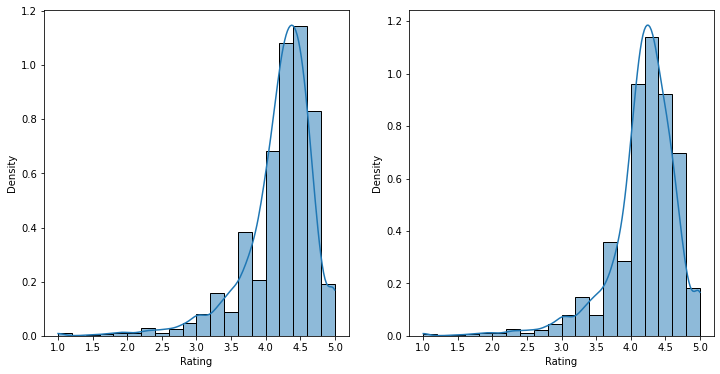

In [43]:
from scipy.stats import norm

fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.histplot(df_playstore, x='Rating', stat='density', bins=20, kde=True, ax=ax[0])
sns.histplot(df_playstore_imputed, stat='density', x='Rating', bins=20, kde=True, ax=ax[1])

# Export processed dataset

In [46]:
df_playstore_export = df_playstore_final.reset_index()
df_playstore_export.to_csv('cleaned_googleplaystore.csv', index=False)

# References
https://medium.com/the-research-nest/data-science-tutorial-analysis-of-the-google-play-store-dataset-c720330d4903
https://www.researchgate.net/publication/341370060_KNN_Imputation_Missing_Value_For_Predictor_App_Rating_on_Google_Play_Using_Random_Forest_Method